<a href="https://colab.research.google.com/github/sayanbanerjee32/feedback-prize-effectiveness/blob/main/basic_lm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install fastkaggle if not available
!pip install -Uq fastai
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

# !pip install -Uq 'timm>=0.6.2.dev'
!pip install -Uq pynvml
from fastkaggle import *

In [2]:
from pathlib import Path
import fastai
fastai.__version__

'2.7.7'

In [3]:
# config depending on whether this is running on kaggle or collab
is_colab = True
comp = 'feedback-prize-effectiveness'
if is_colab:
    model_save_path = Path('/content/'+comp+'_out/models')
else:
    model_save_path = Path('/kaggle/working/'+comp+'/models')

In [4]:
# import colab libraries
if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
if is_colab:
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/Kaggle_api_auth/kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
# This permissions change avoids a warning on Kaggle tool startup.
if is_colab:
    !chmod 600 ~/.kaggle/kaggle.json

In [7]:
path = setup_comp(comp)
path

Path('feedback-prize-effectiveness')

In [8]:
from fastai.text.all import *
set_seed(32)

## Language model for original text

In [9]:
# In this cell fastai TextDataLoader functions are overridden to allow taking output 
# directory as input so that the toknised data is not written in data input directory
# in Kaggle, data input directory is read-only
from fastai.text.core import _tokenize_files
@delegates(_tokenize_files)
def tokenize_folderOP(path, extensions=None, folders=None,
                      output_dir=None, skip_if_exists=True, **kwargs):
    """replacement of fastai.text.core.tokenize_folder so that it passes
     output_dir as input to _tokenize_files"""
    path,extensions = Path(path),ifnone(extensions, ['.txt'])
    files = get_files(path, extensions=extensions, recurse=True, folders=folders)
    def _f(i,output_dir): return output_dir/files[i].relative_to(path)
    return _tokenize_files(_f, files, path, output_dir, 
                           skip_if_exists=skip_if_exists, **kwargs)

class TokenizerOP(Tokenizer):
    """Wrapper class for fastai.text.core.Tokenizer class to override
    from_folder method to take output_dir as input and call the overridden
    method tokenize_folderOP"""
    def __init__(self, tok, rules=None, counter=None,
                 lengths=None, mode=None, sep=' '):
        super().__init__(tok, rules=rules, counter=counter,
                 lengths=lengths, mode=mode, sep=sep)
    
    @classmethod
    @delegates(tokenize_folderOP, keep=True)
    def from_folder(cls, path, tok=None, rules=None, output_dir = None, **kwargs):
        path = Path(path)
        if tok is None: tok = WordTokenizer()
        output_dir = tokenize_folderOP(path, tok=tok, rules=rules, 
                                       skip_if_exists = False, 
                                       output_dir = output_dir, **kwargs)
        res = cls(tok, counter=load_pickle(output_dir/fn_counter_pkl),
                  lengths=load_pickle(output_dir/fn_lengths_pkl),
                  rules=rules, mode='folder')
        res.path,res.output_dir = path,output_dir
        return res


class TextBlockOP(TextBlock):
    "Overriding TextBlock for user defined output dir"
    def __init__(self, tok_tfm, vocab=None, is_lm=False,
                 seq_len=72, backwards=False, **kwargs):
        super().__init__(tok_tfm, vocab=vocab, is_lm=is_lm,
                 seq_len=seq_len, backwards=backwards, **kwargs)
    @classmethod
    @delegates(TokenizerOP.from_folder, keep=True)
    def from_folder(cls, path, vocab=None, is_lm=False, seq_len=72,
                    backwards=False, min_freq=3, max_vocab=60000,output_dir =None,
                    **kwargs):
        "Build a `TextBlock` from a `path` - calls TokenizerOP and provides output_dir as input"
        return cls(TokenizerOP.from_folder(path, output_dir = output_dir, **kwargs), vocab=vocab, is_lm=is_lm, seq_len=seq_len,
                   backwards=backwards, min_freq=min_freq, max_vocab=max_vocab)
        
class TextDataLoadersOP(TextDataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for NLP problems"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, train='train', valid='valid', valid_pct=None,
                    seed=None, vocab=None, text_vocab=None, is_lm=False,
                    tok_tfm=None, seq_len=72, splitter=None,
                    backwards=False, output_dir =None, **kwargs):
        "This is to override same method from TextDataLoaders to accept and pass output_dir as input"
        if splitter is None:
            splitter = GrandparentSplitter(train_name=train,
                                           valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct,
                                                                                                      seed=seed)
        blocks = [TextBlockOP.from_folder(path, text_vocab, is_lm, seq_len, backwards,
                                          tok=tok_tfm, output_dir = output_dir)]
        if not is_lm: blocks.append(CategoryBlock(vocab=vocab))
        get_items = partial(get_text_files, folders=[train,valid]) if valid_pct is None else get_text_files
        dblock = DataBlock(blocks=blocks,
                           get_items=get_items,
                           splitter=splitter,
                           get_y=None if is_lm else parent_label)
        return cls.from_dblock(dblock, path, path=path, seq_len=seq_len, **kwargs)


In [10]:
tok_path = model_save_path / 'train_tok'
tok_path.mkdir(parents=True, exist_ok=True)
dls_lm = TextDataLoadersOP.from_folder(path / 'train', is_lm=True,
                                       valid_pct=0.1, output_dir = tok_path)
# TextDataLoaders.from_folder(path / 'train', is_lm=True, valid_pct=0.1, )
dls_lm.show_batch(max_n=5)

,text,text_
0,"xxbos xxmaj dear xxmaj principal , \n\n i heard about your new requirements on community service and students in our school performing community service . i just wanted to give you my opinion on your expectation and i think it is n't a very good idea for it to be mandatory to perform community service . xxmaj it gives less opportunities for students to succeed in their goals , and it takes","xxmaj dear xxmaj principal , \n\n i heard about your new requirements on community service and students in our school performing community service . i just wanted to give you my opinion on your expectation and i think it is n't a very good idea for it to be mandatory to perform community service . xxmaj it gives less opportunities for students to succeed in their goals , and it takes out"
1,xxup help xxup the xxup country xxup on xxup doing xxup the xxup right xxup things xxup like xxup doing xxup recycling . xxup picking xxup up xxup trash . xxup cause i xxup think xxup that xxup students xxup should xxup get xxup together xxup in xxup help xxup our xxup school xxup by xxup doing xxup work . xxup being xxup the xxup person xxup who xxup clean xxup the,help xxup the xxup country xxup on xxup doing xxup the xxup right xxup things xxup like xxup doing xxup recycling . xxup picking xxup up xxup trash . xxup cause i xxup think xxup that xxup students xxup should xxup get xxup together xxup in xxup help xxup our xxup school xxup by xxup doing xxup work . xxup being xxup the xxup person xxup who xxup clean xxup the xxup
2,"reason why this cell phone policy could result in a positive outcome for our school is it could maybe even save lives . xxmaj for example , if there is a fatal emergency in the cafeteria that involves choking , a student could simply xxunk 911 to get an ambulance there as soon as possible . \n\n xxmaj there may be some issues when first putting the policy in order , but","why this cell phone policy could result in a positive outcome for our school is it could maybe even save lives . xxmaj for example , if there is a fatal emergency in the cafeteria that involves choking , a student could simply xxunk 911 to get an ambulance there as soon as possible . \n\n xxmaj there may be some issues when first putting the policy in order , but once"
3,to be a doctor they will be happy helping in the hospital . xxmaj there are too much different way to tell the to help the community . xxmaj other thing that you can do is to call a person that helps the community to give them an speech or something like that . \n\n xxmaj sincerely : xxup student_name xxbos xxmaj in the xxup us many people use different methods to,be a doctor they will be happy helping in the hospital . xxmaj there are too much different way to tell the to help the community . xxmaj other thing that you can do is to call a person that helps the community to give them an speech or something like that . \n\n xxmaj sincerely : xxup student_name xxbos xxmaj in the xxup us many people use different methods to get
4,"stimulation . \n\n xxmaj finally , a common problem found in adults is an inability to separate home and work life ; this begins at a young age when children fail to make the clear distinction between home and school . xxmaj by allowing students to participate in school from their home , it will make this distinction even less clear which will not only affect the child 's present life but",". \n\n xxmaj finally , a common problem found in adults is an inability to separate home and work life ; this begins at a young age when children fail to make the clear distinction between home and school . xxmaj by allowing students to participate in school from their home , it will make this distinction even less clear which will not only affect the child 's present life but also"


In [11]:
learn_lm = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

In [12]:
learn_lm.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.758809,3.441625,0.324200,31.237667,01:10


In [13]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.560555,3.335599,0.340226,28.095200,01:25
1,3.368963,3.226841,0.359026,25.199930,01:20
2,3.294534,3.142902,0.371320,23.171015,01:25
3,3.159416,3.089717,0.380249,21.970858,01:19
4,3.088670,3.059013,0.385740,21.306520,01:20
5,3.021531,3.031625,0.389521,20.730898,01:23
6,2.924235,3.011608,0.392790,20.320045,01:24
7,2.896526,3.005138,0.394094,20.188995,01:20
8,2.840461,3.004692,0.394719,20.180002,01:20
9,2.820560,3.005007,0.394773,20.186357,01:15


In [14]:
model_save_path.mkdir(parents=True, exist_ok=True)
learn_lm.save_encoder(model_save_path / 'finetuned')

## Text classification

In [15]:
# create data loaders
df = pd.read_csv(path/'train.csv')
dls = TextDataLoaders.from_df(df, text_col='discourse_text',
                              label_col='discourse_effectiveness',
                              text_vocab=dls_lm.vocab)
dls.show_batch(max_n=3)

,text,category
0,xxbos xxmaj you can search the website up so that you can finished it the assignment to handle it in to your teacher if you missing anything from your others class you can finished with your others class you have with your xxunk . xxmaj if you stuck on the question go asked your teacher to helped you out now go to any comptuer that you wanted to be in you have to sign in thorugh your computer to xxunk in now you hace to wait xxunk the screen show up and now go to the website that is on your paper to finished on your assignment on your homework . \n\n xxmaj first now go to any comptuer that you wanted to be in you have to sign in thorugh your computer to xxunk in now you hace to wait xxunk the screen is done . xxmaj now listen,Ineffective
1,"xxbos "" xxmaj attention students , participate in at least one extracurricular activity , "" said my principal . ' \n\n "" one of these days again ? "" "" i hate this school , we do this every week . "" generic_name why do you like doing this so much ? "" "" he s letting us play sports , work on the year book , and even have free talking time . "" generic_name said . xxmaj out of nowhere , \n\n "" generic_name and generic_name come here ! "" \n\n xxmaj me and generic_name looked at each other and said ' where in trouble ' xxmaj we went to xxmaj mr . generic_name xxmaj office and he asked \n\n "" are you boys going to do any activity 's ? ' xxmaj we were xxunk harder than ever . "" yes sir "" generic_name said ,",Ineffective
2,"xxbos xxmaj driveways , home garages , and street parking and forbidden in the experiment of the outskirts on the xxunk district . xxmaj in a place called xxmaj vauban 's streets are completly "" car - free "" . xxmaj the only places that are not car free are downtown near the tram . xxmaj you can only have two places to park and those two places are home , and large garages only at the edge of the developement it costs $ 40 , xxrep 3 0 . xxmaj fifty - seven percent sold a car to move here , and seventy percent of families do not own a car . xxmaj they say "" when i had a car i was always tense . xxmaj xxunk happier this way "" . xxmaj suburbs have linchpin called automobiles . xxmaj up to fifty percent in some car- intensive",Ineffective


In [16]:
learn = text_classifier_learner(dls, AWD_LSTM, 
                                drop_mult=0.5,
                                metrics=[accuracy,F1Score(average='weighted')]).to_fp16()

learn = learn.load_encoder(model_save_path / 'finetuned')

SuggestedLRs(valley=0.0014454397605732083, slide=0.033113110810518265)

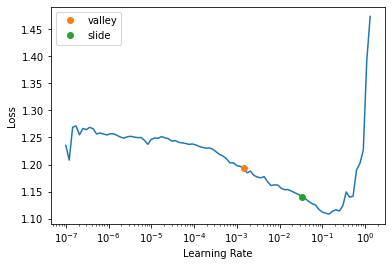

In [17]:
learn.lr_find(suggest_funcs=(valley, slide))

In [18]:
learn.fine_tune(5, 0.01)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.852129,0.813576,0.629947,0.604834,00:47


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.783872,0.783501,0.647627,0.596648,01:01
1,0.760788,0.758988,0.666123,0.637571,00:55
2,0.694553,0.765172,0.669251,0.655516,00:56
3,0.580162,0.820989,0.665035,0.644512,01:05
4,0.495612,0.859342,0.658915,0.645970,00:57


In [19]:
model_save_path.mkdir(parents=True, exist_ok=True)
learn.export(f'{model_save_path}/basic_lm_text_learner.pkl')

## Test submission

In [20]:
test_df = pd.read_csv(path/'test.csv')
test_df.rename(columns = {'discourse_text':'text'}, inplace = True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   discourse_id    10 non-null     object
 1   essay_id        10 non-null     object
 2   text            10 non-null     object
 3   discourse_type  10 non-null     object
dtypes: object(4)
memory usage: 448.0+ bytes


In [21]:
tst_dl = dls.test_dl(test_df)
tst_dl.show_batch()

,text
0,"xxbos xxmaj taking other peoples advice and doing what they say may lead to a great outcome . xxmaj when you receive other opinions whether they are good or bad you will be able to look at them from a different point of view . xxmaj for example , xxmaj when a group of people give you advice on yourself , you then know how they look at you as a person . xxmaj everyone looks at certain things from a different xxunk . xxmaj how someone else looks at it may be how its supposed to be viewed in life ."
1,"xxbos xxmaj everyone is different and may have more experience than you . xxmaj seeking other peoples opinion can cause you to gain a new skill or lesson . xxmaj for example , someones advice could teach you how to do something the correct way . xxmaj many people are very different and have experience different things in life . xxmaj seeking advice from others can teach you a lot . xxmaj we all learn from our mistakes in life , by sharing your past experiences you may prevent someone else from making the same mistake ."
2,xxbos xxmaj when making a decision there is a chance that you can become very stressed and overwhelmed . xxmaj being stressed can cause a person to give up on what they are doing . xxmaj having multiple opinions from people can make choosing an option less difficult and more easier . xxmaj the information that you receive from others may have a special meaning in the future . xxmaj other peoples opinion can make a person feel confident in making the right choice .
3,xxbos xxmaj you can learn from others experiences by seeking the advice that someone give you . xxmaj making decisions can cause stress on a person . xxmaj relating to someones advice may higher your self - esteem because you no longer feel left out . xxmaj ask others for advice when making a difficult decision . xxmaj when you seek others opinion more opportunities are available fro yourself .
4,xxbos xxmaj making choices in life can be very difficult . xxmaj people often ask for advice when they can not decide on one thing . xxmaj it 's always good to ask others for their advice when making a choice . xxmaj when you have multiple opinions you have the ability to make the best choice for yourself .
5,xxbos xxmaj seeking multiple opinions can help a person make a better choice
6,xxbos xxmaj seeking others opinion can be very helpful and beneficial .
7,xxbos a great chance to learn something new
8,xxbos can be very helpful and beneficial .


In [22]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
probs

tensor([[4.0611e-01, 5.9175e-01, 2.1488e-03],
        [8.4944e-01, 9.2870e-02, 5.7692e-02],
        [1.0792e-01, 9.5213e-03, 8.8256e-01],
        [6.6280e-01, 2.1236e-01, 1.2484e-01],
        [1.0792e-01, 9.5213e-03, 8.8256e-01],
        [4.1662e-01, 5.8239e-01, 9.8158e-04],
        [4.0577e-01, 5.9271e-01, 1.5203e-03],
        [8.4476e-01, 5.0534e-02, 1.0471e-01],
        [5.4864e-01, 4.4713e-01, 4.2259e-03],
        [3.0846e-01, 6.9106e-01, 4.7475e-04]])

In [23]:
# column names for probabilities
probs_df = pd.DataFrame(probs.numpy(),columns = dls.vocab[1])
probs_df

,Adequate,Effective,Ineffective
0,0.406105,0.591746,0.002149
1,0.849438,0.092870,0.057692
2,0.107919,0.009521,0.882559
3,0.662798,0.212361,0.124841
4,0.107919,0.009521,0.882559
5,0.416625,0.582394,0.000982
6,0.405773,0.592707,0.001520
7,0.844760,0.050534,0.104707
8,0.548642,0.447133,0.004226
9,0.308460,0.691065,0.000475


In [24]:
probs_df["discourse_id"] = test_df["discourse_id"]
probs_df.to_csv('submission.csv', index=False)
!head submission.csv

Adequate,Effective,Ineffective,discourse_id
0.4061053,0.5917459,0.002148808,a261b6e14276
0.8494382,0.092869595,0.057692204,5a88900e7dc1
0.10791949,0.009521278,0.88255924,9790d835736b
0.66279846,0.21236095,0.12484056,75ce6d68b67b
0.10791949,0.009521278,0.88255924,93578d946723
0.4166247,0.58239377,0.0009815764,2e214524dbe3
0.4057729,0.59270686,0.0015202573,84812fc2ab9f
0.8447595,0.05053397,0.10470652,c668ff840720
0.5486415,0.44713268,0.004225909,739a6d00f44a


In [25]:
# not working for this competetion
# if not iskaggle:
#     from kaggle import api
#     api.competition_submit_cli('submission.csv', 'initial', comp)

In [26]:
if not iskaggle:
    push_notebook('saan', comp,
                  title='Feedback effeciveness initial model with Language model',
                  file='/content/drive/MyDrive/Colab Notebooks/basic_lm_model.ipynb',
                  competition=comp, private=True, gpu=True)